**Let's do some  work to see how clustered our reviews are, using the lat-long coordinates for each businesses**

In [1]:
import pandas as pd
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from shapely.ops import transform
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain
from functools import partial
import pickle
from collections import Counter
import tqdm

import json

%matplotlib inline

In [2]:
#Determine the lat/long boundaries of the map
shp = fiona.open('char_ct_shapefile.shp')
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]
print bds

(-81.05802899999999, 35.0016358721739, -80.550297, 35.515102999999996)


In [3]:
pits_bizs = pickle.load(open('charlotte_bizs.p','rb'))

In [4]:
with open('categories.json') as data_file:    
    categories = json.load(data_file)

In [5]:
titles = []
for category in categories:
    titles.append(category['title'])

In [6]:
cafes = set([title for title in titles if 'Coff' in title])

In [7]:
cafes

{u'Coffee & Tea', u'Coffee & Tea Supplies', u'Coffeeshops'}

In [8]:
#Extract latlong coordinates from the reviews:
biz_lats = []
biz_lons = []
rev_counts = []
zipcodes = []

gent_bizs = []
gent_lats = []
gent_lons = []

for biz in pits_bizs:
    biz_lats.append(biz['latitude'])
    biz_lons.append(biz['longitude'])
    rev_counts.append(len(biz['reviews']))
    zipcodes.append(['full_address'][-5:])
    
    if set(biz['categories']).intersection(cafes):
        gent_bizs.append(biz)
        gent_lats.append(biz['latitude'])
        gent_lons.append(biz['longitude'])
    
#Let's just use a dataframe
#bizframe = pd.DataFrame(pits_bizs)
#bizframe['zipcodes'] = [address[-5:] for address in bizframe['full_address']]

print len(gent_bizs)

115


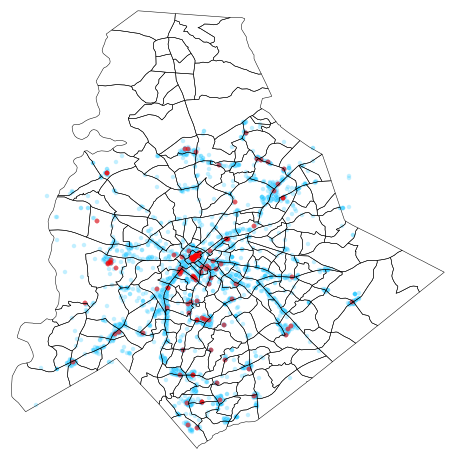

In [62]:
m = Basemap(
    lon_0 = 35.2, #np.mean([coords[0], coords[2]]), 
    lat_0 = -80.8, #np.mean([coords[1], coords[3]]), 
    llcrnrlon = coords[0] - extra * w,
    llcrnrlat = coords[1] - extra * h,
    urcrnrlon = coords[2] + extra * w,
    urcrnrlat = coords[3] + extra * h,
    #projection='merc',
    lat_ts = 0, resolution = 'i', suppress_ticks = True)

fig=plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
fig.set_size_inches(10,7)
#plt.title('Charlotte Census Tracts')

m.scatter(biz_lons,biz_lats,alpha = 0.3, marker = 'o',lw=.25,
          facecolor='#33ccff', edgecolor='w',antialiased=True)

m.scatter(gent_lons,gent_lats,alpha = 0.6, marker = 'o',lw=.25,
          facecolor='#FF0000', edgecolor='r',antialiased=True)

m.readshapefile(
    'char_ct_shapefile',
    'ctmap')

fig.set_size_inches(10, 8)
#plt.savefig('char_bizs.png', dpi=100, alpha=True)


In [10]:
m.ctmap_info[3]['NAME']

'15.07'

In [11]:
map_points = pd.Series([Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(biz_lons, biz_lats)])

In [12]:
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.ctmap],
    'ct_num': [float(tract['NAME']) for tract in m.ctmap_info]})

In [13]:
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.9,
    zorder=4))

In [14]:
# Find out which census tract a business is in
for biz in pits_bizs:
    biz['ct_num'] = 0

for biz, lat, lon in zip(pits_bizs,biz_lats,biz_lons):
    
    map_point = Point(m(lon,lat))
   
    for ct_num, poly in zip(df_map['ct_num'],df_map['poly']):
        
        tract_poly = prep(poly)
        if tract_poly.contains(map_point):
            biz['ct_num'] = ct_num
            break



In [52]:
#pickle.dump(pits_bizs,open('charlotte_bizs_census.p','wb'))

In [15]:
df_map['num_bizs'] = pd.Series(np.zeros(len(df_map['ct_num'])))
for biz in tqdm.tqdm(pits_bizs):
    
    ct_num = biz['ct_num']
    row = df_map[df_map['ct_num'] == ct_num].index

    df_map.ix[row,'num_bizs']+= 1

In [16]:
counter = 0
df_map['num_cafes'] = pd.Series([0]*len(df_map['ct_num']))
for biz in tqdm.tqdm(gent_bizs):
    ct_num = biz['ct_num']
    
    row = df_map[df_map['ct_num'] == ct_num].index
    
    df_map.ix[row,'num_cafes'] += 1
    counter+=1


In [17]:
print len(gent_bizs)
print counter
print df_map['num_cafes'].sum()
print len(pits_bizs)
print df_map['num_bizs'].sum()

115
115
115
5199
5187.0


In [19]:
df_map['cafe_density'] = df_map['num_cafes']/df_map['num_bizs']

In [59]:
gent_cts = [38.05,37,36,41,7,8,9,14,18.02]
ungent_cts = [38.06, 38.07,38.08,38.02,32.01,39.02,39.02,40,43.05,43.03,43.04,43.02,42,45,44,54.01,54.03,54.04,51,50,49,48,46,45,42,52,53.06,23,18.01,17.01,21,19.19,17.02,16.07,16.09,19.12,16.06,16.05,16.03,16.08,15.04,15.09,15.10,13,53.01,52,53.06,53.05,53.06,58.07,54.07,54.01]
ungent_cts_all = [38.08, 38.07, 38.06, 32.01, 38.02, 39.02, 39.03, 43.05, 42   , 43.05, 43.03, 43.04, 43.02, 45   , 44   , 46   , 45   , 54.01, 48   , 50   , 49   , 54.03, 54.04, 51   , 53.01, 52   , 53.05, 53.07, 53.08, 53.06, 15.09, 15.1 , 13   , 15.04, 16.08, 16.03, 16.09, 19.12, 16.07, 16.06, 16.05, 17.01, 17.02, 19.18, 19.19, 23, 18.02, 21, 40,18.01,47]

In [60]:
print len(ungent_cts)
print len(ungent_cts_all)

52
51


In [57]:
is_gent = []
ungent_sample = []
ungent_all = []
for ct_num in df_map['ct_num']:
    if float(ct_num) in gent_cts:
        is_gent.append(True)
    else:
        is_gent.append(False)
    if float(ct_num) in ungent_cts:
        ungent_sample.append(True)
    else:
        ungent_sample.append(False)
    if float(ct_num) in ungent_cts_all:
        ungent_all.append(True)
    else:
        ungent_all.append(False)
df_map['is_gent'] = is_gent
df_map['ungent_sample'] = ungent_sample
df_map['ungent_all'] = ungent_all

In [39]:
# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['num_cafes'].notnull()].num_cafes.values,
    initial=300,
    k=5)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenk_bins': breaks.yb}, index=df_map[df_map['num_cafes'].notnull()].index)
df_map = df_map.join(jb) # these are already compleeted. Running 2nd time causes errors
#df_map.jenks_bins.fillna(-1, inplace=True)

In [40]:
# Calculate Jenks natural breaks for density
breaks2 = nb(
    df_map[df_map['num_bizs'].notnull()].num_bizs.values,
    initial=10,
    k=5)
# the notnull method lets us match indices when joining
jb2 = pd.DataFrame({'jenk_bins2': breaks2.yb}, index=df_map[df_map['num_bizs'].notnull()].index)
df_map = df_map.join(jb2) # these are already compleeted. Running 2nd time causes errors
#df_map.jenks_bins.fillna(-1, inplace=True)

In [38]:
df_map = df_map.drop('jenk_bins',1)
df_map = df_map.drop('jenk_bins2',1)

In [46]:
df_map

,ct_num,poly,patches,num_bizs,num_cafes,cafe_density,is_gent,ungent_sample,jenk_bins,jenk_bins2,ungent_all
0,1.00,"POLYGON ((-80.85257799999999 35.2196, -80.8551...","Poly((-80.8526, 35.2196) ...)",497,22,0.044266,False,False,3,4,False
1,6.00,"POLYGON ((-80.830012 35.221281, -80.832132 35....","Poly((-80.83, 35.2213) ...)",23,0,0.000000,False,False,0,1,False
2,13.00,"POLYGON ((-80.78790499999999 35.24665, -80.783...","Poly((-80.7879, 35.2466) ...)",10,0,0.000000,False,True,0,0,True
3,15.07,"POLYGON ((-80.73789499999999 35.236914, -80.74...","Poly((-80.7379, 35.2369) ...)",2,0,0.000000,False,False,0,0,False
4,16.05,"POLYGON ((-80.77057499999999 35.219418, -80.77...","Poly((-80.7706, 35.2194) ...)",3,0,0.000000,False,True,0,0,True
5,16.08,"POLYGON ((-80.75923899999999 35.237858, -80.73...","Poly((-80.7592, 35.2379) ...)",3,0,0.000000,False,True,0,0,True
6,18.02,POLYGON ((-80.77640199999999 35.18215199999999...,"Poly((-80.7764, 35.1822) ...)",31,0,0.000000,True,False,0,2,True
7,19.15,"POLYGON ((-80.755584 35.167498, -80.756896 35....","Poly((-80.7556, 35.1675) ...)",22,0,0.000000,False,False,0,1,False
8,19.20,"POLYGON ((-80.744416 35.170034, -80.745369 35....","Poly((-80.7444, 35.17) ...)",10,0,0.000000,False,False,0,0,False
9,20.04,"POLYGON ((-80.78373499999999 35.137823, -80.78...","Poly((-80.7837, 35.1378) ...)",6,0,0.000000,False,False,0,0,False


In [26]:
# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

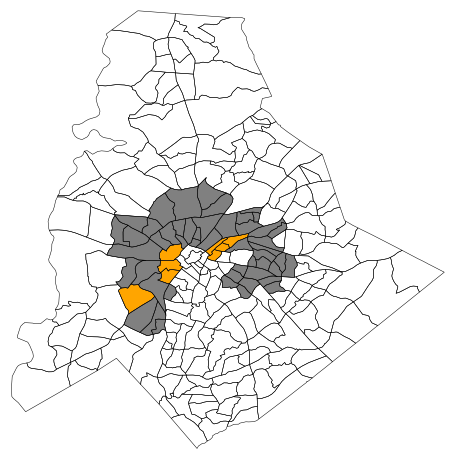

In [61]:
fig=plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
#plt.title('Charlotte Coffeeshop Density')

m.readshapefile(
    'char_ct_shapefile',
    'ctmap')

jenks_labels = ["<= %d cafes (%s tracts)" % (b, c) for b, c in zip( breaks.bins, breaks.counts)]
#jenks_labels2 = ["<= %d businesses (%s tracts)" % (b, c) for b, c in zip( breaks2.bins, breaks2.counts)]

# use a colour ramp - we'll be converting it to a map using cmap()
cmap = plt.get_cmap('Reds')
#cmap = plt.get_cmap('Blues')


# draw wards with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#555555', lw=.2, alpha=1., zorder=4))
#pc = PatchCollection(df_map['patches'], match_original=True)

pc2 = PatchCollection(df_map[df_map['is_gent']==True]['patches'],match_original=True)
pc3 = PatchCollection(df_map[df_map['ungent_sample']==True]['patches'],match_original=True)
pc4 = PatchCollection(df_map[df_map['ungent_all']==True]['patches'],match_original=True)

# impose our colour map onto the patch collection
norm = Normalize()

#pc.set_facecolor(cmap(norm(df_map['jenk_bins'].values)))
#pc.set_facecolor(cmap(norm(df_map['jenk_bins2'].values)))

pc2.set_facecolor('orange')
pc3.set_facecolor('tan')
pc4.set_facecolor('grey')
#ax.add_collection(pc)
ax.add_collection(pc2)
ax.add_collection(pc4)
#ax.add_collection(pc3)

# Add a colour bar
#cb = colorbar_index(ncolors=len(jenks_labels), cmap=cmap, shrink=0.5, labels=jenks_labels)
#cb = colorbar_index(ncolors=len(jenks_labels2), cmap=cmap, shrink=0.5, labels=jenks_labels2)
cb.ax.tick_params(labelsize=20)

fig.set_size_inches(16, 8)
plt.tight_layout
#plt.savefig('bizdensity.png', dpi=200, alpha=True)
#plt.savefig('cafedensity.png', dpi=200, alpha=True)



plt.show()

In [313]:
print df_map[df_map['ungent_sample']==True].num_bizs.sum()
print df_map[df_map['is_gent']==True].num_bizs.sum()
test = df_map[df_map['is_gent']==True]

596.0
249.0
